**D3APL: Aplicações em Ciência de Dados** <br/>
IFSP Campinas

Prof. Dr. Samuel Martins (Samuka) <br/><br/>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Animal Dataset - v1
We will evaluate some **multiclass classification** CNNs to predict the classes of the **Animal Dataset**: https://www.kaggle.com/datasets/alessiocorrado99/animals10


Target goals:
- Proposed CNN's Architecture
- Dataset Preprocessing
    + Import the image data
    + Preprocessing the data
        - Image rescaling
        - Normalization
    + Save the preprocessed data
    + Convert the images into a _feature matrix (X)_ and a list of _target labels (y)_
- Train CNN
    - Use early stopping regularization
- Evaluate a simple CNN architecture

## 1. Set up

#### 1.1 TensorFlow

In [1]:
import tensorflow as tf

2023-04-27 20:22:15.635495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 20:22:16.464469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.12.0'

**GPU available?**

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-04-27 20:22:22.688700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-27 20:22:22.808758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-27 20:22:22.808976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### 1.2 Fixing the seed for reproducibility (optional)
That's a try for reprodubility in Keras. See more on:
- https://stackoverflow.com/a/59076062
- https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

In [4]:
import os
import tensorflow as tf
import numpy as np
import random

def reset_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    
# make some random data
reset_random_seeds()

### 1.3. Dataset
**Animal Dataset**: https://www.kaggle.com/datasets/alessiocorrado99/animals10

#### 1.3.1 Load the dataset
**Balanced dataset**: _'../datasets/animals-dataset/animals_dataset_balanced.csv'_

In [5]:
import pandas as pd

In [6]:
dataset_df = pd.read_csv('../datasets/animals-dataset/animals_dataset_balanced.csv')

In [7]:
dataset_df

,image_pathname,class
0,../datasets/animals-dataset/raw-img/cane/OIP-A...,dog
1,../datasets/animals-dataset/raw-img/cane/OIP-1...,dog
2,../datasets/animals-dataset/raw-img/cane/OIP-S...,dog
3,../datasets/animals-dataset/raw-img/cane/OIP-P...,dog
4,../datasets/animals-dataset/raw-img/cane/OIP-N...,dog
...,...,...
9995,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel
9996,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel
9997,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel
9998,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel


#### 1.3.2 Dataset Info

In [8]:
dataset_df["class"].unique()

array(['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow',
       'sheep', 'spider', 'squirrel'], dtype=object)

In [9]:
class_names = sorted(dataset_df["class"].unique())
n_classes = len(class_names)

print(f'Number of classes: {n_classes}')
print(f'Classes: {class_names}')

Number of classes: 10
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [10]:
# number of samples per class
dataset_df['class'].value_counts()

class
dog          1000
horse        1000
elephant     1000
butterfly    1000
chicken      1000
cat          1000
cow          1000
sheep        1000
spider       1000
squirrel     1000
Name: count, dtype: int64

### 1.4. Split the data


Since we will _preprocess the images_, we would like to _keep the pathname_ for the **original images** just in case of recovering them. <br/>
Therefore, we will split the dataset directly from the `Pandas DataFrame`.

We will also defined a _fixed validation set_ for comparison purposes.

In [11]:
from sklearn.model_selection import train_test_split

# for a stratified sampling, we need to pass the labels
labels = dataset_df['class']

dataset_df_full_train, dataset_df_test = train_test_split(dataset_df, test_size=0.2, random_state=42, stratify=labels)

In [14]:
dataset_df_full_train.shape

(8000, 2)

In [16]:
dataset_df_full_train.head()

,image_pathname,class
670,../datasets/animals-dataset/raw-img/cane/OIP-P...,dog
5755,../datasets/animals-dataset/raw-img/gatto/1843...,cat
2579,../datasets/animals-dataset/raw-img/elefante/O...,elephant
2249,../datasets/animals-dataset/raw-img/elefante/O...,elephant
9190,../datasets/animals-dataset/raw-img/scoiattolo...,squirrel


In [13]:
dataset_df_test.shape

(2000, 2)

In [17]:
# for a stratified sampling, we need to pass the labels
labels_full_train = dataset_df_full_train['class']

dataset_df_train, dataset_df_val = train_test_split(dataset_df_full_train, train_size=0.8, random_state=42, stratify=labels_full_train)

In [18]:
# checking class balancing in the training set
dataset_df_train['class'].value_counts()

class
chicken      640
horse        640
cat          640
spider       640
butterfly    640
squirrel     640
dog          640
elephant     640
sheep        640
cow          640
Name: count, dtype: int64

In [19]:
# checking class balancing in the validation set
dataset_df_val['class'].value_counts()

class
spider       160
elephant     160
squirrel     160
cow          160
butterfly    160
cat          160
horse        160
chicken      160
sheep        160
dog          160
Name: count, dtype: int64

In [20]:
# checking class balancing in the training set
dataset_df_test['class'].value_counts()

class
dog          200
elephant     200
cow          200
chicken      200
sheep        200
spider       200
cat          200
horse        200
butterfly    200
squirrel     200
Name: count, dtype: int64

## 2. Building and Training a CNN via Keras

### 2.1 Defining the Network Architecture
That's a simple CNN for _Multiclass Classification_:
- **INPUT [64x64x3]**
- CONV [32, 4x4x3, 'valid']
- RELU
- MAX_POOL [2x2, stride=(1,1)]
- CONV [32, 4x4x3, 'valid']
- RELU
- MAX_POOL [2x2, stride=(1,1)]
- FLATTEN
- FC [256]
- RELU
- FC [256, 'relu']
- FC [10, 'softmax']  # number of classes

- optimizer: SGD with `learning_rate=0.01`
- kernel_initializer: "glorot_uniform"
- bias_initializer: "zeros"
- **Early stopping**

In [24]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense


def build_cnn(input_shape=(64, 64, 3), n_classes=10):
    model = Sequential([
        # feature extraction
        Conv2D(filters=32, kernel_size=(4,4), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Flatten(),
        
        # Fully-Connected Neural Network ==> MLP
        Dense(256, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

In [25]:
input_shape = (64, 64, 3)

model = build_cnn(input_shape, n_classes)
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

2023-04-27 20:36:28.387380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-27 20:36:28.387606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-27 20:36:28.387728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 256)               1

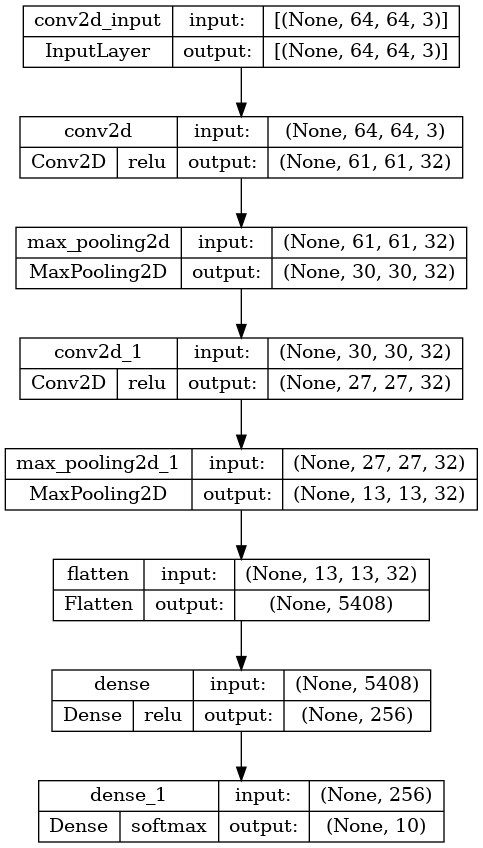

In [27]:
from tensorflow.keras.utils import plot_model
# vertical
plot_model(model, show_shapes=True, show_layer_activations=True)

### 2.2 Image Preprocessing

- **Image Resizing**
    + Since the **input layer's shape** and the **images' shape** ***are different***, we need to **resize** the images to the **input layer's shape**.
    + Let's use the function `c2.resize()` for that: https://learnopencv.com/image-resizing-with-opencv/#resize-by-wdith-height
- **Intensity (feature) Scaling**
    + Animals dataset contain 24-bit color images, i.e., it is a color image where each channel is a 8-bit grayscale image (values from 0 to 255)
    + We will simply rescale the values to [0, 1] by dividing them by 255.
- **Label Encoder**
    + Encode the string classes into class integers from 0 to n_classes-1
    + https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
    
Create a function that performs all these steps.

In [ ]:
# training a Label Encoder from the train set
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(dataset_df_train['class'])

label_encoder.classes_

In [ ]:
# preprocessing the train set
X_train, y_train = preprocess_animals_dataset(dataset_df_train, label_encoder, new_dims=(64, 64))

In [ ]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train (classes): {np.unique(y_train)}')
print(f'y_train.shape: {y_train.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

In [ ]:
# preprocessing the validation set
X_val, y_val = preprocess_animals_dataset(dataset_df_val, label_encoder, new_dims=(64, 64))

In [ ]:
print(f'X_val.shape: {X_val.shape}')
print(f'y_val (classes): {np.unique(y_val)}')
print(f'y_val.shape: {y_val.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_val: {X_val.min()}')
print(f'Max. value of X_val: {X_val.max()}\n')

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_val[0])

In [ ]:
# preprocessing the test set
X_test, y_test = preprocess_animals_dataset(dataset_df_test, label_encoder, new_dims=(64, 64))

In [ ]:
print(f'X_test.shape: {X_test.shape}')
print(f'y_test (classes): {np.unique(y_test)}')
print(f'y_test.shape: {y_test.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_test: {X_test.min()}')
print(f'Max. value of X_test: {X_test.max()}\n')

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_test[0])

Since this function may be useful in other notebooks, let's create a **python file/module** to make it available:

**File:** `animals_utils.py`

In [ ]:
import animals_utils

In [ ]:
# preprocessing the train set
X_train, y_train = animals_utils.preprocess_animals_dataset(dataset_df_train, label_encoder, new_dims=(64, 64))

In [ ]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train (classes): {np.unique(y_train)}')
print(f'y_train.shape: {y_train.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

#### **Observation**

While _image resizing_ and _feature scaling_ **don't learn** any parameter, our _label encoding_ learns the convertion between _class names_ to _sequential integers_ considering the **entire data**. <br/>
To consider a _real scenario_, we shouldn't do that. We should _split the data_ into _training and testing sets_ ***before* applying any preprocessing** to avoid _snooping bias_. <br/>

One better way is to create a **Scikit-learn `Pipeline`** to _preprocess our data_. For that, we would have to create a _custom sklearn transformer_ to resize the images as well as for the simple feature normalization, and label encoding. Then, we could use this **preprocessing step** in production to preprocess any data!

Another way is consider the _preprocessing steps_ as **layers** from your Neural Network: https://www.tensorflow.org/tutorials/images/data_augmentation

### 2.3 Save the preprocessed data

In [ ]:
import os

out_dir = '../datasets/animals-dataset/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
dataset_df_full_train.to_csv(os.path.join(out_dir, 'full_train.csv'), index=False)

dataset_df_train.to_csv(os.path.join(out_dir, 'train.csv'), index=False)
np.save(os.path.join(out_dir, 'train_data_64x64x3.npy'), X_train)
np.save(os.path.join(out_dir, 'train_labels.npy'), y_train)

dataset_df_val.to_csv(os.path.join(out_dir, 'validation.csv'), index=False)
np.save(os.path.join(out_dir, 'validation_data_64x64x3.npy'), X_val)
np.save(os.path.join(out_dir, 'validation_labels.npy'), y_val)

dataset_df_test.to_csv(os.path.join(out_dir, 'test.csv'), index=False)
np.save(os.path.join(out_dir, 'test_data_64x64x3.npy'), X_test)
np.save(os.path.join(out_dir, 'test_labels.npy'), y_test)

### 2.5 Training with Early Stopping

In case of GPU drivers, we can monitor its use by [_gpustat_](https://github.com/wookayin/gpustat).

On terminal, use: `gpustat -cpi`


In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

#### **Visualizing the training history**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

In [ ]:
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

## 3. Evaluating and Predicting New Samples by using our Overfitted Model

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

In [ ]:
model.evaluate(X_test, y_test)

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

In [ ]:
y_test_proba = model.predict(X_test)
y_test_proba

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

In [ ]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

In [ ]:
from sklearn.metrics import classification_report

class_names = label_encoder.classes_

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

We got a **poor accuracy** of 0.51.

#### **Visualizing some misclassified image**

In [ ]:
y_test_class_name = label_encoder.inverse_transform(y_test)
y_test_pred_class_name = label_encoder.inverse_transform(y_test_pred)

In [ ]:
misclassification_mask = y_test_class_name != y_test_pred_class_name

**Sheep**

In [ ]:
sheep_error_mask = misclassification_mask & (y_test_class_name == "sheep")

np.argwhere(sheep_error_mask)[:3]

In [ ]:
img_idx = 9

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

In [ ]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
img_idx = 18

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

In [ ]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

**Dog**

In [ ]:
dog_error_mask = misclassification_mask & (y_test_class_name == "dog")

np.argwhere(dog_error_mask)[:3]

In [ ]:
img_idx = 0

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

In [ ]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
img_idx = 13

plt.imshow(X_test[img_idx])
plt.title(f'True: {y_test_class_name[img_idx]}, Predicted: {y_test_pred_class_name[img_idx]}')

In [ ]:
# original image
img_path = dataset_df_test.iloc[img_idx]['image_pathname']

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Exercise

Repeat the experiments considering different:
-  values for _learning_rate_ of SGD
- optimizers (e.g., 'nadam')
- kernel regularizer (e.g., 'l2')
- Dropout regularization